!["Project"](Images/Slide1.jpg)

# Content
> ###  - Introduction
> ### - Data collection and Preprocessing
> ### - Exploratory Data Analysis (EDA)
> ### - Model
> ### - Results and Implications
> ### - Remaining work

# <center>Introduction</center>

The project aims at providing a application using which we can select the restaurants based on are preference like ambience, food, etc. We are using Yelp food dataset which is available online. And can be downloaded from the link below

###  __[Dataset](https://yelp.com/dataset/download)__

# <center>Data collection and preprocessing</center>

### Dataset description:

The dataset is downloaded from Yelp official website. The downloaded data is in JSON format it has 6 files named business.json, review.json, user.json, checkin.json, tip.json and, photo.json. The file on which we are concentrating is review.json

For the scope of this project we have narrowed down to reviews of restaurants in Illinos. We have converted that file into review.json using the following code

### Dataset preprocessing:

We removed all the null values and kept the data related to restaurants and remove data related to cars, plumbing etc.

In [1]:
import pandas as pd
import numpy as np

In [2]:
def filter_restaurant_businesses(file):
    df = pd.read_json(file, lines=True)
    filtered_df = df[(df.categories.str.contains('Restaurants')==True) & (df.state.str.contains('IL')==True)]
    il_business = filtered_df.business_id.to_string(index=False)
    with open('./il_business_ids.txt', 'w') as outfile:
        outfile.write(il_business)

In [3]:
# filter_restaurant_businesses("../../Yelp_dataset/business.json")

In [4]:
with open("./il_business_ids.txt","r") as il_business_ids:
    sample = il_business_ids.readline()
    print(sample)

mofOjB6flg-eAWOFbOkHfQ



**Now we got all the list of business ids that belong to Illinois**.

#### The review.json file is very large so we split it using the following command

head -1000000 review.json > reviews_1000000.json

The above command saves part of reviews as reviews_1000000.json

In [5]:
def filter_il_reviews(file):
    df = pd.read_json(file, lines=True)
    business_ids = df.business_id.to_list()
    df.set_index('business_id', inplace=True)
    reviews_df = pd.DataFrame()

    with open('./il_business_ids.txt', 'r') as infile:
        for b_id in infile:
            b_id = b_id.strip()
            if b_id in business_ids:
                data = df.loc[[b_id]]
                reviews_df = reviews_df.append(data)
    with open('./il_reviews.csv', 'a') as outfile:
        reviews_df.to_csv(outfile, header=False)

In [6]:
# filter_il_reviews("../../Yelp_dataset/reviews_1000000.json")

In [7]:
import pandas as pd
import pandas_profiling

In [8]:
df = pd.read_csv("il_reviews.csv")

In [9]:
df.head(2)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,mofOjB6flg-eAWOFbOkHfQ,0,2017-12-02 20:22:26,0,8MTptiOpUeuPUFZgtfk9Vw,1,I would have given this restaurant zero stars ...,1,9-vNlkNQL7OJQZ7-U965Ww
1,mofOjB6flg-eAWOFbOkHfQ,0,2017-12-16 04:31:05,0,ofpfzn8LV4nJ2pE6IlTVdg,1,So...no. Just...no. Before I picked up a plate...,1,-FcgbLbKjPgpst5qFU3-lg


In [10]:
pandas_profiling.ProfileReport(df)

Number of variables,9
Number of observations,6703
Total Missing (%),0.0%
Total size in memory,471.4 KiB
Average record size in memory,72.0 B
Numeric,4
Categorical,4
Boolean,0
Date,0
Text (Unique),1
Rejected,0


##### From the above graph we come to know that columns business_id, cool, date, funny, review_id, stars, useful, user_id are not useful so we drop it 

In [11]:
# df.drop(["cool","date","funny","useful"],axis = 1)

# <center>Exploratory Data Analysis (EDA) </center>

### Labeling data 

In [12]:
def label_data(path):
    df = pd.read_csv(path)
    reviews = df.text
    
    food_tags = np.where(df.text.str.contains('food|vegetables|veggie|veggies|meat|chicken|pho|soup|lunch|dinner|menu|bland|flavor'), 'food', None)
    cleanliness_tags = np.where(df.text.str.contains('clean|dirty|hygiene'), 'cleanliness', None)
    service_tags = np.where(df.text.str.contains('service|waitress|hostess|waiter|worker|staff|'), 'service', None)
    ambience_tags = np.where(df.text.str.contains('ambience|place'), 'ambience', None)

    tags = zip(food_tags, cleanliness_tags, service_tags, ambience_tags)
    tag_list = list(tags)
    tag_list = [list(tags) for tags in tag_list]
    valid_tag_list = []
    for tags in tag_list:
        for tag in tags:
            valid_list = [t for t in tags if t is not None]
        valid_tag_list.append(valid_list)

    df['tags'] = valid_tag_list
    return df

In [13]:
df_Labeled = label_data("./il_reviews.csv")

In [14]:
df_Labeled.head(2)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,tags
0,mofOjB6flg-eAWOFbOkHfQ,0,2017-12-02 20:22:26,0,8MTptiOpUeuPUFZgtfk9Vw,1,I would have given this restaurant zero stars ...,1,9-vNlkNQL7OJQZ7-U965Ww,"[food, cleanliness, service]"
1,mofOjB6flg-eAWOFbOkHfQ,0,2017-12-16 04:31:05,0,ofpfzn8LV4nJ2pE6IlTVdg,1,So...no. Just...no. Before I picked up a plate...,1,-FcgbLbKjPgpst5qFU3-lg,"[food, service]"


### Initial Data Analysis part 1

In [15]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# Analysis part 2
import string
import collections
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk import pos_tag

# Common to both
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words+=["restaurant", "restaurants", "food", "would", "u", "n't", "ve"]
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [16]:
reviews_data = pd.read_csv("./il_reviews.csv", header = 0)

In [17]:
reviews_data.head(2)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,mofOjB6flg-eAWOFbOkHfQ,0,2017-12-02 20:22:26,0,8MTptiOpUeuPUFZgtfk9Vw,1,I would have given this restaurant zero stars ...,1,9-vNlkNQL7OJQZ7-U965Ww
1,mofOjB6flg-eAWOFbOkHfQ,0,2017-12-16 04:31:05,0,ofpfzn8LV4nJ2pE6IlTVdg,1,So...no. Just...no. Before I picked up a plate...,1,-FcgbLbKjPgpst5qFU3-lg


In [18]:
reviews_data.describe()

,cool,funny,stars,useful
count,6703.000000,6703.000000,6703.000000,6703.000000
mean,0.332836,0.374907,3.476652,1.215277
std,0.902303,1.434581,1.441803,2.218730
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,2.000000,0.000000
50%,0.000000,0.000000,4.000000,0.000000
75%,0.000000,0.000000,5.000000,2.000000
max,16.000000,37.000000,5.000000,38.000000


In [19]:
reviews_data.corr()   # corerraltion between numerical data

,cool,funny,stars,useful
cool,1.000000,0.386800,0.095492,0.608676
funny,0.386800,1.000000,-0.133010,0.363115
stars,0.095492,-0.133010,1.000000,-0.064078
useful,0.608676,0.363115,-0.064078,1.000000


Cool, funny and useful describes the number of cool, funny and useful votes given to the review. From the above dataset description, it is observed that less than 25% of the reviewers has voted the reviews as cool, funny or useful.

So, the cool, funny and useful votes data is not useful here.

In [20]:
reviews_data.drop(["cool","date","funny","useful"],axis = 1,inplace=True) # dropping cool, date, funny and useful columns
reviews_data.sample()

,business_id,review_id,stars,text,user_id
1567,CrIWqmuO2uQWwl3z11K_BA,fhPd8XJIqhU0vp8qr_5scA,4,First time visiting this place and I was very ...,y4Ny_RnD_ubgtYh_fRgalg


### Data Visualization 

In [21]:
reviews_data.stars.value_counts() # counts the stars rating in the reviews data

5    2198
4    1687
1    1044
3     974
2     800
Name: stars, dtype: int64

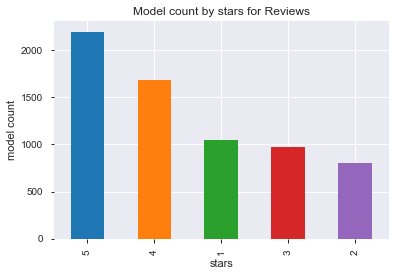

In [22]:
# plotting the stars rating againt count
ax = reviews_data.stars.value_counts().plot.bar(figsize=(6,4), title="Model count by stars for Reviews");  
ax.set(xlabel = "stars", ylabel = "model count");

From the above chart, we can analyze that the majority of reviews have received 5 start ratings... 

### Generating a word cloud for more visualization
-  Word cloud with stop words and without lemmatiztion to analyze the top words used in the reviews.

(-0.5, 399.5, 199.5, -0.5)

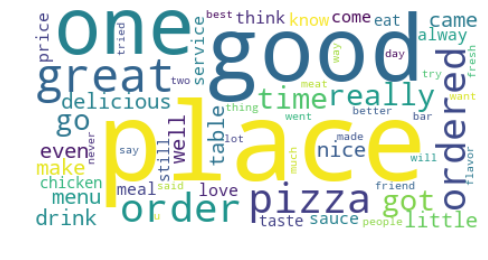

In [23]:
text = " ".join(x for x in reviews_data.text)  # raw reviews

# Create stopword list:
stop_words = set(STOPWORDS)
stop_words.update(["restaurant","restaurants", "food"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stop_words, min_font_size = 10, background_color = "white").generate(text)

# Display the generated image:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

### Business data file contains the information regarding Il restaurants 

In [24]:
business_data = pd.read_csv("./IL_BusinessData.csv", header = 0)
business_data.head(2)

,attributes,business_id,categories,name,review_count,stars,state
0,"{'WiFi': ""u'no'"", 'RestaurantsReservations': '...",mofOjB6flg-eAWOFbOkHfQ,"Sushi Bars, Buffets, Restaurants, Chinese",ChinaTown Buffet,72,2.5,IL
1,"{'RestaurantsGoodForGroups': 'True', 'Business...",m4DwPVxmFDQE_FnGIOa3cQ,"Buffets, Chinese, Restaurants",Sunny China Buffet,15,3.5,IL


In [25]:
business_data.drop(["attributes"], axis = 1, inplace = True)  # dropping attributes column

In [26]:
pandas_profiling.ProfileReport(business_data)

Number of variables,6
Number of observations,672
Total Missing (%),0.0%
Total size in memory,31.6 KiB
Average record size in memory,48.1 B
Numeric,2
Categorical,3
Boolean,0
Date,0
Text (Unique),0
Rejected,1


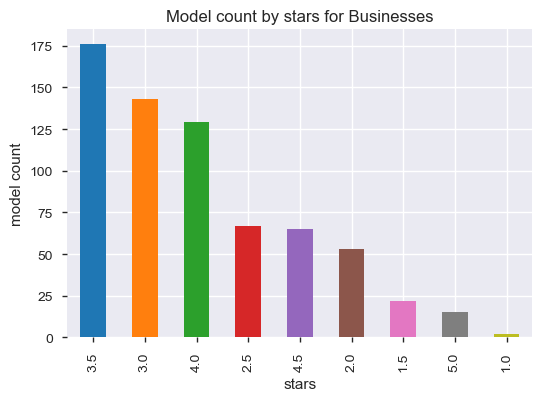

In [27]:
# plotting the stars rating againt count for business data

ax = business_data.stars.value_counts().plot.bar(figsize=(6,4), title="Model count by stars for Businesses");
ax.set(xlabel = "stars", ylabel = "model count");

### Initial Data Analysis - Part 2

In [28]:
reviews_data.head(2)

,business_id,review_id,stars,text,user_id
0,mofOjB6flg-eAWOFbOkHfQ,8MTptiOpUeuPUFZgtfk9Vw,1,I would have given this restaurant zero stars ...,9-vNlkNQL7OJQZ7-U965Ww
1,mofOjB6flg-eAWOFbOkHfQ,ofpfzn8LV4nJ2pE6IlTVdg,1,So...no. Just...no. Before I picked up a plate...,-FcgbLbKjPgpst5qFU3-lg


In [29]:
df[["business_id","text"]].as_matrix()[0]

array(['mofOjB6flg-eAWOFbOkHfQ',
       "I would have given this restaurant zero stars if the app allowed it. This is a disgusting restaurant. You can find roaches lurching around the food. The 'clean' dishes next to buffet items are mostly dirty. Just look at the bottom of the plate. This restaurant should really be inspected by authorities."],
      dtype=object)

In [30]:
processedData = list(df[["business_id","text"]].as_matrix())

In [31]:
processedData[6702]

array(['cDGaMsCAx8guR1IUrxLxWA',
       "The shrimp pho was a good treat on a chilly January afternoon in Champaign. It is served bland, but this can be resolved with bottles of Sriracha and other hot sauces on the counter.\n\nI was disappointed that they don't accept American Express, but that might be just me."],
      dtype=object)

### Tokenization

In [32]:
WNlemma = nltk.WordNetLemmatizer()

In [33]:
def tokenize(x):
    res = []
    ans = []
    ans.append(x[0])
    data = x[1]
    
    for val in sent_tokenize(data):
        val = val.strip(string.punctuation).lower()
        filtered_text = [w for w in word_tokenize(val) if not w in stop_words]
 
        lemmatized_tokens = [WNlemma.lemmatize(w.strip(string.punctuation)) for w in filtered_text if w.strip(string.punctuation)!=""]
        
        res = res+lemmatized_tokens
    
    ans.append(res)
    
    return ans

In [34]:
map(tokenize,processedData)

In [35]:
clean_reviews = list(map(tokenize,processedData))
clean_text = []

for x in clean_reviews:
    clean_text.append(x[1])

token_list = []
for x in clean_text:
    token_list = token_list + x

- Word cloud with stop words and without lemmatiztion to analyze the top words used in the reviews.

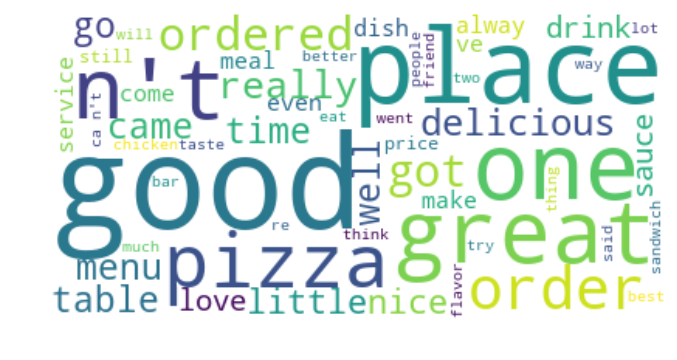

In [36]:
text = ""
for x in token_list:
    text = text + " " + x
# text = str(token_list)  # raw reviews

# Create stopword list:
stop_words = set(STOPWORDS)
stop_words.update(["restaurant","restaurants", "food"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stop_words, min_font_size = 10, background_color = "white").generate(text)

# Display the generated image:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

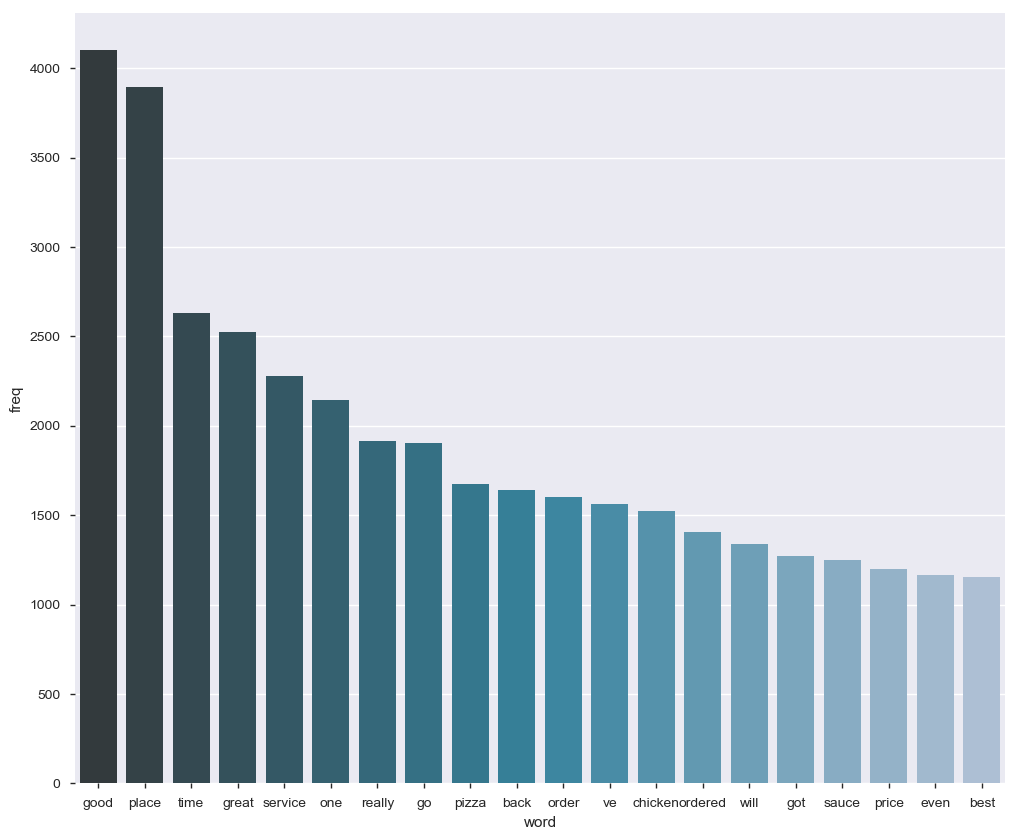

In [37]:
cv = CountVectorizer()
bow = cv.fit_transform(token_list)
# print (cv.get_feature_names())
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show()

# <center>Text Analytics Models </center>

In [38]:
temp = df["text"]

In [39]:
processedData = df.text.tolist()

In [40]:
WNlemma = nltk.WordNetLemmatizer()

In [41]:
def tokenize_Lemmatize_POS(data):
    ans = []
    for val in sent_tokenize(data):
        val = val.strip(string.punctuation)
        ans.extend([WNlemma.lemmatize(w.strip(string.punctuation)) for w in word_tokenize(val) if w.strip(string.punctuation)!=""])
    return pos_tag(ans)

In [42]:
tagged_POS = list(map(tokenize_Lemmatize_POS,processedData))

In [43]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [44]:
def construct_tf_idf(reviews):
    t = Tokenizer()
    t.fit_on_texts(reviews)
    tf_idf = t.texts_to_matrix(reviews, mode='count')
    return tf_idf

In [45]:
tf_idf = construct_tf_idf(processedData)

### Sentimental Analysis 

In [46]:
# Reading positive and negative words text file
with open("positive-words.txt",'r') as f:
    positive_words=[line.strip() for line in f]
with open("negative-words.txt",'r') as f:
    negative_words=[line.strip() for line in f]

In [47]:
df = pd.read_csv("./il_reviews.csv")

df.drop(["cool","date","funny","useful"],axis = 1,inplace=True)

In [48]:
# Pre-processing Reviews data
processedData = list(df[["business_id","text","user_id"]].as_matrix())

In [49]:
# Performs naive Sentiment Analysis 
def naive_sentiment(x):
    res = []
    ans = []
    positive_tokens=[]
    negative_tokens=[]
    negations=['not', 'too', 'n\'t', 'no', 'cannot', 'neither','nor']
    final_review=[]
    data = x[1]
    for val in sent_tokenize(data):
        val = val.strip(string.punctuation)
        for token in word_tokenize(val):
            if token in positive_words:   
                  positive_tokens.append(token)
            else:
                  if token in negative_words:
                        negative_tokens.append(token)
                    
    if len(positive_tokens)>len(negative_tokens):
        final_review.append("positive")  
    else:
        if len(negative_tokens)>len(positive_tokens):
            final_review.append("negative")
        else:
            if len(positive_tokens)==len(negative_tokens):
                final_review.append("neutral")  
    return final_review

In [50]:
processed_doc = list(map(naive_sentiment,processedData))

In [51]:
review_sentiment = []

In [52]:
for x in processed_doc:
    review_sentiment+=x

In [53]:
df['sentiment'] = review_sentiment

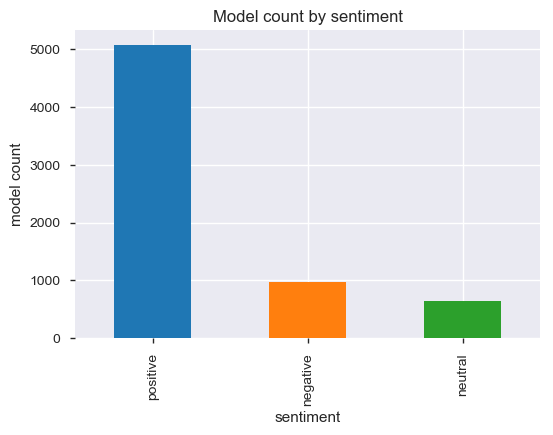

In [54]:
ax = df.sentiment.value_counts().plot.bar(figsize=(6,4), title="Model count by sentiment");  
ax.set(xlabel = "sentiment", ylabel = "model count");
plt.show()

### Building ANN Model for new review 

In [55]:
def build_model_ann(tf_idf, labels):
    binarizer = MultiLabelBinarizer()
    labels = binarizer.fit_transform(labels)

    X = tf_idf
    y = labels
    X_train, X_test = X[:5000], X[5000:]
    y_train, y_test = y[:5000], y[5000:]
    
    model = Sequential()
    model.add(Dense(1000, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.1))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd)

    model.fit(X_train, y_train, epochs=5, batch_size=2000)

    preds = model.predict(X_test)
    preds[preds>=0.5] = 1
    preds[preds<0.5] = 0
    label = ['food', 'cleanliness', 'ambience', 'service']
    print(classification_report(y_test, preds, target_names=label))

In [56]:
df_Labeled.head(1)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,tags
0,mofOjB6flg-eAWOFbOkHfQ,0,2017-12-02 20:22:26,0,8MTptiOpUeuPUFZgtfk9Vw,1,I would have given this restaurant zero stars ...,1,9-vNlkNQL7OJQZ7-U965Ww,"[food, cleanliness, service]"


In [57]:
build_model_ann(tf_idf,df_Labeled.tags)

Epoch 1/5
5000/5000 [==============================] - 18s 4ms/step - loss: 0.6696
Epoch 2/5
5000/5000 [==============================] - 15s 3ms/step - loss: 0.5660
Epoch 3/5
5000/5000 [==============================] - 16s 3ms/step - loss: 0.5039
Epoch 4/5
5000/5000 [==============================] - 16s 3ms/step - loss: 0.4723
Epoch 5/5
5000/5000 [==============================] - 18s 4ms/step - loss: 0.4572
             precision    recall  f1-score   support

       food       0.53      0.69      0.60       635
cleanliness       0.00      0.00      0.00       139
   ambience       0.69      1.00      0.82      1174
    service       1.00      1.00      1.00      1703

avg / total       0.78      0.91      0.83      3651



C:\Users\Nikhil\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
